# Random Forests - Key Insights

The key to the success of random forests is to build several randamized decision trees and combine the predictions from all of them. One can randomize each tree based on the combinations of following factors:

### Training Data Randomization
Each tree can be trained on randomised samples of training data. This may not need the desired randomization if the variance in dataset across different samples isn't much.

### Candidate Rule Space
Randomizing the candidate rule space is one good alternative. Here we can randomly pick only subset of features and limit the exploration to small set of rules within the sampled feature space.

# Randomized Split Criteria

Here is a function that creates random subspaces and searches through random decision functions to add variance to the decision trees. This function is the only difference between the normal decision tree and randomized tree. 

```python
	def getBestSplit(self, node, X,y ):
		paramSampleSize = self.subspaceSize
		subSpaceDim = 2

		startIdx = 0
		stopIdx = self.inputSize  

		fSets = np.random.choice(np.arange(startIdx,stopIdx,dtype=np.int32), paramSampleSize*subSpaceDim ).reshape(paramSampleSize, subSpaceDim )
		splitModelParams = np.random.normal(0, 1, (paramSampleSize, subSpaceDim+1))
		
		tParams = np.zeros((paramSampleSize, 2))
		tParams[:,1] = -np.Inf
		tParams[:,0] = 2*np.sqrt(2)*np.random.normal(0, 1, paramSampleSize)


		bestGain = 0
		splitGain = 0
		leftDataIDX = None
		leftDataIDX_tmp = None
		rightDataIDX = None
		rightDataIDX_tmp = None
	
		fSubSpace = None
		fSubSpace_tmp = None

		splitModel = None
		splitModel_tmp = None

		splitThresh = None
		splitThresh_tmp = None

		for idx in range(0, paramSampleSize):
			fSubSpace_tmp = fSets[idx, :]
			splitModel_tmp = splitModelParams[idx,:]
			splitThresh_tmp = tParams[idx,:]

			(splitGain, leftDataIDX_tmp, rightDataIDX_tmp) = self.getNodeSplitScore(node, fSubSpace_tmp, splitModel_tmp, splitThresh_tmp,X,y)

			if splitGain > bestGain:
				bestGain = splitGain
				fSubSpace = fSubSpace_tmp

				splitModel = splitModel_tmp 
				splitThresh = splitThresh_tmp

				leftDataIDX = leftDataIDX_tmp
				rightDataIDX = rightDataIDX_tmp

		return (leftDataIDX, rightDataIDX, fSubSpace, splitModel, splitThresh)

```

# Random Forests Classifier

In random forests classifier, we just combine the results from multiple randomized trees. Following code gives the implementation of Random Forests based on RandomizedTree, which uses the randomized version of finding the best split rule.

```python
import numpy as np
import time

from RandomizedTree import RandomizedTree

class RandomForestsClassifier(object):
	def __init__(self, numTrees=10, stopCriteria='maxDepth', stopValue=2, subspaceSize=500):

		self.numTrees = numTrees
		self.stopCriteria = stopCriteria
		self.stopValue = stopValue
		self.subspaceSize = subspaceSize
		
		self.trees = []

	def train(self, X, y, Xtest, ytest):
		self.numClasses = len(np.unique(y))
		self.inputSize = X.shape[1]
		
		(self.labelMap, y) = self.mapLabels(y.flatten())
	   
		totalScores = np.zeros((X.shape[0], self.numClasses))
		totalTestScores = np.zeros((Xtest.shape[0], self.numClasses))

		for idx in range(self.numTrees):
			print 'Building tree: %d/%d'%(idx+1, self.numTrees)

			start = time.time()
			rt = RandomizedTree(self.subspaceSize,self.stopCriteria, self.stopValue)
			rt.train(X, y)
			print 'trained in ', time.time() - start

			# train accuracy
			start = time.time()
			(pred, scores) = rt.predict(X)
			accuracy = 1 - 1.0*sum(pred != y.flatten())/len(y)
			totalScores = totalScores + scores
			idxes = totalScores.argmax(axis=1)
			totalAccuracy = 1 - 1.0*sum(idxes != y.flatten())/len(y)
			print 'train prediction', time.time() - start

			# test accuracy
			start = time.time()
			(pred, scores) = rt.predict(Xtest)
			pred = self.mapbackLabels(pred)
			testAccuracy = 1 - 1.0*sum(pred != ytest.flatten())/len(ytest)
			totalTestScores = totalTestScores + scores
			idxes = totalTestScores.argmax(axis=1)
			idxes = self.mapbackLabels(idxes)
			totalTestAccuracy = 1 - 1.0*sum(idxes != ytest.flatten())/len(ytest)
			print 'test prediction', time.time() - start

			self.trees.append(rt)
			 
			print 'Training Completed with Train Accuracy: %f, Test Accuracy: %f'%(accuracy, testAccuracy)
			print 'Combined Train Accuracy: %f, Test Accuracy: %f'%(totalAccuracy, totalTestAccuracy)
	
	def predict(self, X):
		scores = np.zeros((X.shape[0], self.numClasses))

		for rt in self.trees:
		   (pred1, scores1) = rt.predict(X)
		   scores = scores + scores1
		
		scores = scores/self.numTrees
		pred = scores.argmax(axis=1)
		pred = self.mapbackLabels(pred)

		return (pred, scores)
	
	def mapLabels(self, yIn):
		labelMap = np.unique(yIn).astype('int32')
		mappedY = np.zeros(yIn.shape, dtype='int32').flatten()
		for idx in range(len(labelMap)):
			mappedY[yIn == labelMap[idx]] = idx
		
		return (labelMap, mappedY)
	
	def mapbackLabels(self, y):
		return self.labelMap[y]
```

# Random Forests in Action

Let's look at how random forests can classify complex non-linear datasets. 

(200, 2)
Building tree: 1/2
trained in  1.05937981606
train prediction 0.00692009925842
test prediction 0.00639986991882
Training Completed with Train Accuracy: 0.990000, Test Accuracy: 0.990000
Combined Train Accuracy: 0.990000, Test Accuracy: 0.990000
Building tree: 2/2
trained in  0.945525169373
train prediction 0.00666689872742
test prediction 0.00711488723755
Training Completed with Train Accuracy: 0.975000, Test Accuracy: 0.975000
Combined Train Accuracy: 1.000000, Test Accuracy: 1.000000


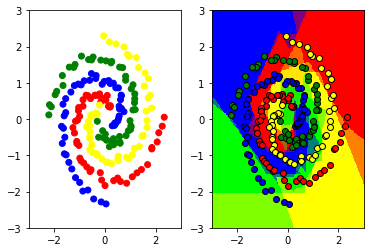

In [3]:
import time 
import numpy as np

import sys

from numpy import random
import matplotlib.pyplot as plt
from RandomForestsClassifier import RandomForestsClassifier

N = 50
t = np.linspace(1, 2*np.pi, N)
x1 = random.normal(t*np.cos(t), 0.2)
y1 = random.normal(t*np.sin(t), 0.2)

t = np.linspace(1, 2*np.pi, N)
x2 = random.normal(t*np.cos(t+1.5708), 0.2)
y2 = random.normal(t*np.sin(t+1.5708), 0.2)

t = np.linspace(1, 2*np.pi, N)
x3 = random.normal(t*np.cos(t+1.5708*2), 0.2)
y3 = random.normal(t*np.sin(t+1.5708*2), 0.2)

t = np.linspace(1, 2*np.pi, N)
x4 = random.normal(t*np.cos(t+1.5708*3), 0.2)
y4 = random.normal(t*np.sin(t+1.5708*3), 0.2)

data1 = np.vstack((x1, y1)).T
data2 = np.vstack((x2, y2)).T
data3 = np.vstack((x3, y3)).T
data4 = np.vstack((x4, y4)).T

data = np.vstack((data1, data2))
data = np.vstack((data, data3))
data = np.vstack((data, data4))
print data.shape

m = np.mean(data, 0)
var = np.var(data, 0)
s = np.sqrt(var) + 1e-10

data = (data - m)/s
labels = np.ones((N, 1),dtype=np.int32)
labels = np.vstack((labels, np.ones((N, 1),dtype=np.int32)*2))
labels = np.vstack((labels, np.ones((N, 1),dtype=np.int32)*3))
labels = np.vstack((labels, np.ones((N, 1),dtype=np.int32)*4))

plt.subplot(121)
colors = ['red']*N + ['yellow']*N + ['green']*N +['blue']*N
plt.scatter(data[:, 0], data[:, 1], c=colors)
plt.xlim(-3,3)
plt.ylim(-3,3)

numClasses = len(np.unique(labels))


rForest = RandomForestsClassifier(numTrees=2, stopCriteria='maxDepth', stopValue=9,subspaceSize=500)
rForest.train(data, labels, data, labels)

w = 201
x = np.linspace(-8, 8, 201)
y = np.linspace(-8, 8, 201)
x, y = np.meshgrid(x, y)

x = x.flatten()
y = y.flatten()
testData = np.vstack((x, y)).T
testData = (testData - m)/s
pred, scores = rForest.predict(testData);

colors = np.array([[1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 1], [1, 0, 1], [0, 1, 1]]).T
colors = colors[:, 0:numClasses]
rgb = np.dot(colors, scores.T)
rgb = rgb - np.min(rgb)
rgb = rgb/np.max(rgb)

plt.subplot(122)
plt.axis('equal')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.imshow(np.reshape(rgb.T, (w, w, 3)), extent=[-3, 3, -3, 3], aspect='auto')

plt.plot(data[np.nonzero(labels == 1)[0], 0], data[np.nonzero(labels == 1)[0], 1], 
    'o', markerfacecolor='red', markeredgecolor='black')
plt.plot(data[np.nonzero(labels == 2)[0], 0], data[np.nonzero(labels == 2)[0], 1], 
    'o', markerfacecolor='yellow', markeredgecolor='black')
plt.plot(data[np.nonzero(labels == 3)[0], 0], data[np.nonzero(labels == 3)[0], 1], 
    'o', markerfacecolor='green', markeredgecolor='black')
plt.plot(data[np.nonzero(labels == 4)[0], 0], data[np.nonzero(labels == 4)[0], 1], 
    'o', markerfacecolor='blue', markeredgecolor='black')
plt.show()